# Obtention de la matrice de flux optique à partir de deux frames

In [2]:
video_index = 3
frame_index = 237

In [3]:
# Load frames 184 and 185 from the video
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the yolo/src directory to the Python path
sys.path.append('src')

# Import the necessary functions
from flow import calculate_flow
from segmentation import VehicleDetector


focal_length = 910
# Use the correct path to the video
video_path = f'../labeled/{video_index}.hevc'

# Open the video
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video at {video_path}")
else:
    # Get total frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")
    
    # Set frame numbers
    frame1_num = frame_index - 1
    frame2_num = frame_index
    print(f"prev frame number: {frame1_num}")
    dil_size = 10
    
    # Get frame 1 - Make sure to reset position and read frames sequentially
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    for i in range(frame1_num):  # +1 because we're 0-indexed
        ret1, frame1 = cap.read()
        if not ret1:
            print(f"Error: Could not read frame {i}")
            break
    
    # Get frame 2 - Continue reading from current position
    ret2, frame2 = cap.read()
    
    if ret1 and ret2:
        # Verify we're at the right frames
        print(f"Current frame position: {int(cap.get(cv2.CAP_PROP_POS_FRAMES))}")
        
        # Initialize vehicle detector
        detector = VehicleDetector()
        
        # Detect vehicles and create masks
        vehicle_mask1 = detector.detect_vehicles(frame1)
        vehicle_mask2 = detector.detect_vehicles(frame2)
        vehicle_mask1 = detector.dilate_mask(vehicle_mask1, dil_size)
        vehicle_mask2 = detector.dilate_mask(vehicle_mask2, dil_size)
        
        # Charger le masque manuel sauvegardé
        mask_path = '../masks/4_mask.png'
        if os.path.exists(mask_path):
            manual_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            # S'assurer que le masque a la même taille que les frames
            if manual_mask.shape != vehicle_mask1.shape:
                manual_mask = cv2.resize(manual_mask, (vehicle_mask1.shape[1], vehicle_mask1.shape[0]))
        else:
            print(f"Attention: masque manuel non trouvé à {mask_path}, un masque vide sera utilisé.")
            manual_mask = np.zeros_like(vehicle_mask1)

        # Combine masks
        combined_mask = detector.combine_masks(manual_mask, vehicle_mask2, vehicle_mask1)

        
        # Convert to grayscale
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        
        # Calculate optical flow
        flow, prev_gray_masked, gray_masked = calculate_flow(gray1, gray2, combined_mask)

Total frames in video: -192153584101141
prev frame number: 236
Current frame position: 237


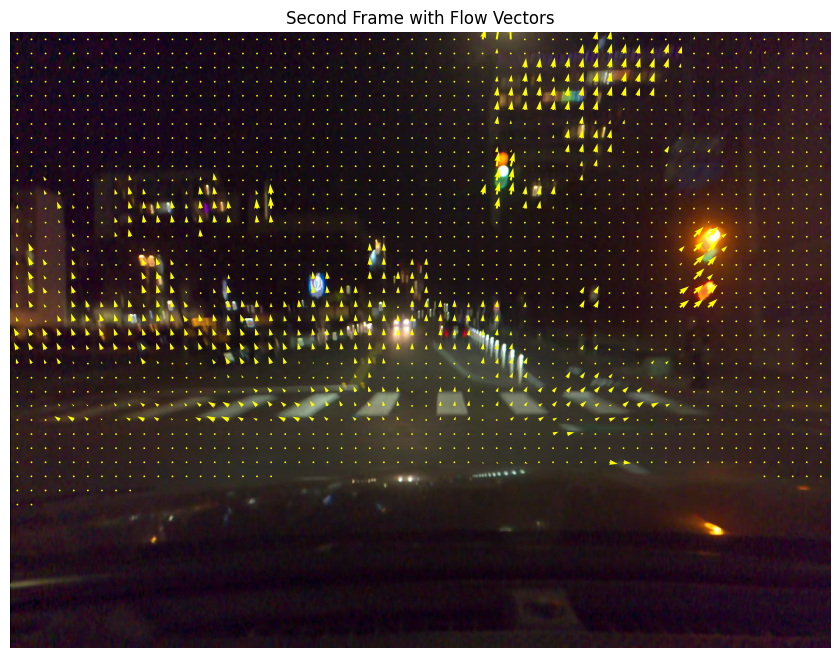

In [4]:
# Display the second frame with flow vectors
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
plt.title('Second Frame with Flow Vectors')

# Plot flow vectors
# Subsample the flow field for better visualization
step = 20  # Adjust this value to change the density of arrows
h, w = flow.shape[:2]
y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
fx, fy = flow[y, x].T

# Create a mask for valid flow vectors (non-zero)
valid = (fx != 0) | (fy != 0)

plt.quiver(x[valid], y[valid], fx[valid], fy[valid], 
           color='yellow', angles='xy', scale_units='xy', scale=1)

plt.axis('off')
plt.show()



# Fonctions pour calculer les colinéarités

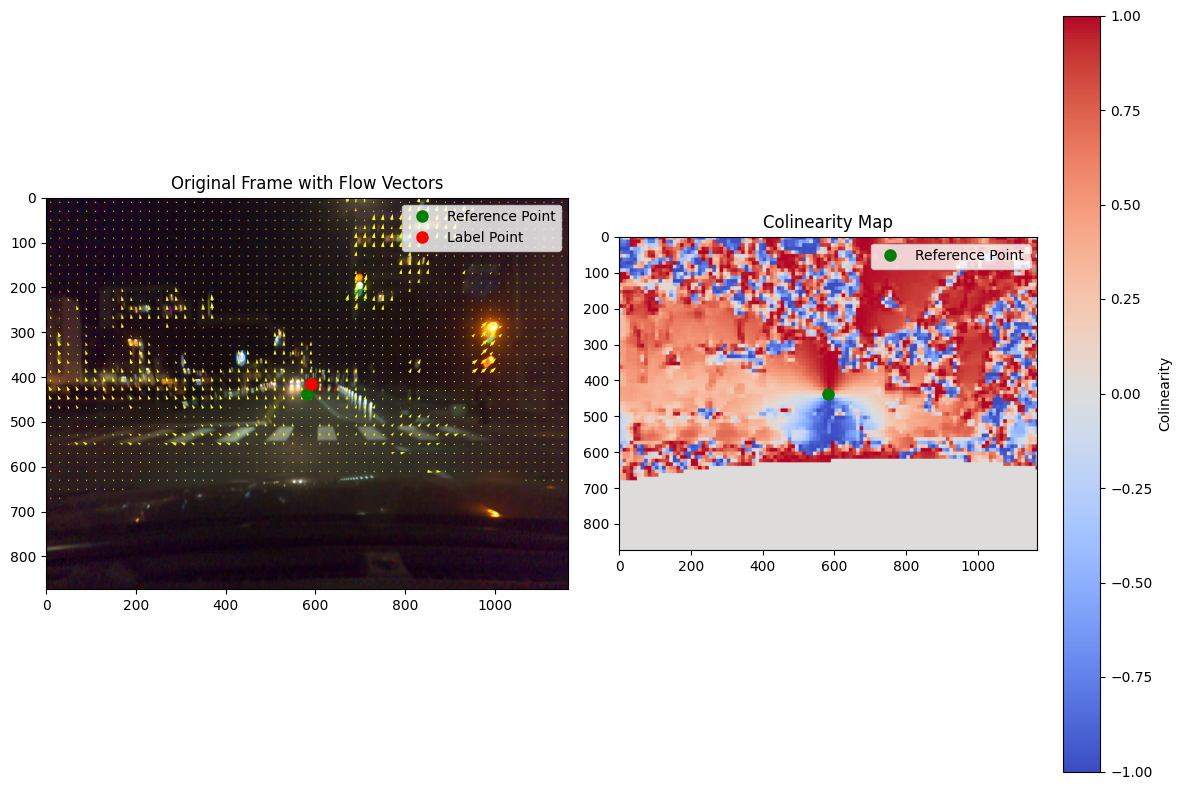

In [12]:
# Load a sample video and compute optical flow
# Use the flow that was already calculated in the previous code
import cv2
import numpy as np
import matplotlib.pyplot as plt
from colinearity_optimization import VanishingPointEstimator
from ground_truth import get_frame_pixels

label_point = get_frame_pixels(video_index, frame_index)

ve = VanishingPointEstimator(
    frame_width=frame2.shape[1], 
    frame_height=frame2.shape[0], 
    use_max_distance=False
)



# Get dimensions from the flow
h, w = flow.shape[:2]

# Compute the colinearity map
pt = (w // 2, h // 2)  # Middle point of the image
colinearity_map = ve.compute_colinearity_map(flow, pt, step=10)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Display the original frame with flow vectors
ax1.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Frame with Flow Vectors')

# Plot flow vectors (downsampled for clarity)
step = 20  # Display every 20th vector for clarity
y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
fx, fy = flow[y, x].T

# Create a mask for valid flow vectors (non-zero)
valid = (fx != 0) | (fy != 0)

ax1.quiver(x[valid], y[valid], fx[valid], fy[valid], 
           color='yellow', angles='xy', scale_units='xy', scale=1)
ax1.plot(pt[0], pt[1], 'go', markersize=8, label='Reference Point')
ax1.plot(label_point[0], label_point[1], 'ro', markersize=8, label='Label Point')
ax1.legend()

# Display the colinearity map
im = ax2.imshow(colinearity_map, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2, label='Colinearity')
ax2.set_title('Colinearity Map')
ax2.plot(pt[0], pt[1], 'go', markersize=8, label='Reference Point')
ax2.legend()

plt.tight_layout()
plt.show()

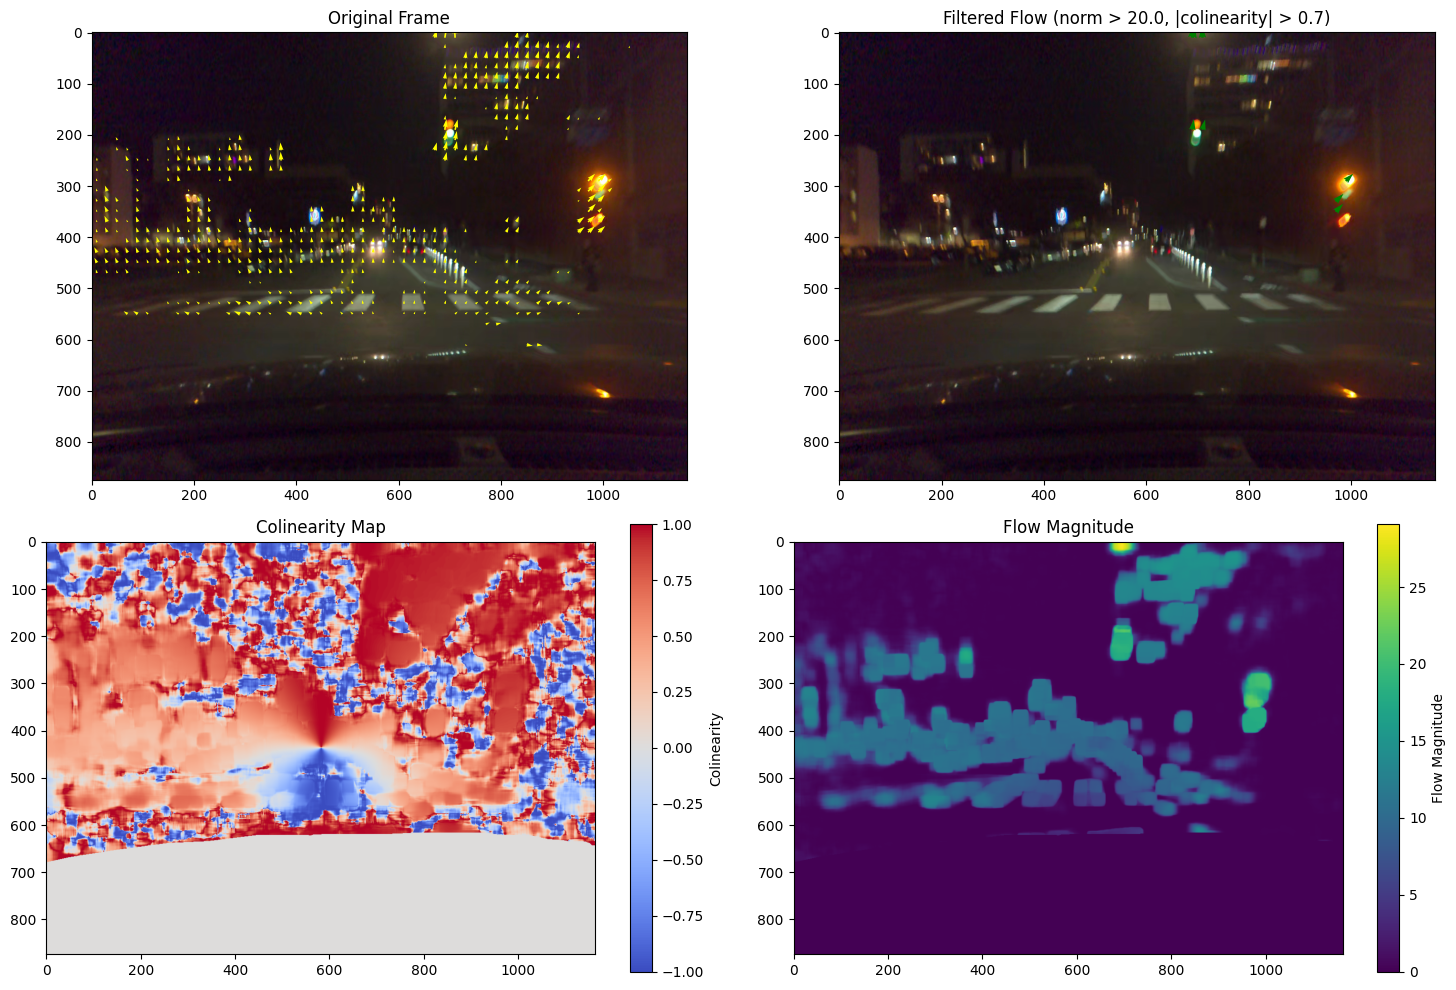

In [26]:
# Create a filtered flow where we keep only vectors with:
# 1. Norm greater than 1e-2
# 2. Colinearity score to the center greater than 0.85
norm_threshold = 2e1
colinearity_threshold = 0.7
h, w = flow.shape[:2]
filtered_flow = np.zeros_like(flow)

# Get the center point of the image
center = (w // 2, h // 2)

# Compute the colinearity map with respect to the center
colinearity_map = ve.compute_colinearity_map(flow, center, step=1)

# Iterate through each pixel
for y in range(h):
    for x in range(w):
        # Calculate the norm of the flow vector
        fx, fy = flow[y, x]
        norm = np.sqrt(fx**2 + fy**2)
        
        # Get the colinearity score at this pixel
        colinearity_score = colinearity_map[y, x]
        
        # Apply the filtering criteria - both conditions must be met
        if norm > norm_threshold and abs(colinearity_score) > colinearity_threshold:
            filtered_flow[y, x] = flow[y, x]

# Visualize the filtered flow
plt.figure(figsize=(15, 10))

# Original flow
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
plt.title('Original Frame')

# Plot original flow vectors (downsampled for clarity)
step = 20
y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
fx, fy = flow[y, x].T
valid = (fx**2 + fy**2) > norm_threshold  # Small threshold for visualization
plt.quiver(x[valid], y[valid], fx[valid], fy[valid], 
           color='yellow', angles='xy', scale_units='xy', scale=1)

# Filtered flow
plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
plt.title(f'Filtered Flow (norm > {norm_threshold}, |colinearity| > {colinearity_threshold})')

# Plot filtered flow vectors
fx_filtered, fy_filtered = filtered_flow[y, x].T
valid_filtered = (fx_filtered**2 + fy_filtered**2) > 0
plt.quiver(x[valid_filtered], y[valid_filtered], 
           fx_filtered[valid_filtered], fy_filtered[valid_filtered],
           color='green', angles='xy', scale_units='xy', scale=1)

# Colinearity map
plt.subplot(2, 2, 3)
plt.imshow(colinearity_map, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Colinearity')
plt.title('Colinearity Map')

# Flow magnitude map
plt.subplot(2, 2, 4)
magnitude = np.sqrt(flow[:,:,0]**2 + flow[:,:,1]**2)
plt.imshow(magnitude, cmap='viridis')
plt.colorbar(label='Flow Magnitude')
plt.title('Flow Magnitude')

plt.tight_layout()
plt.show()


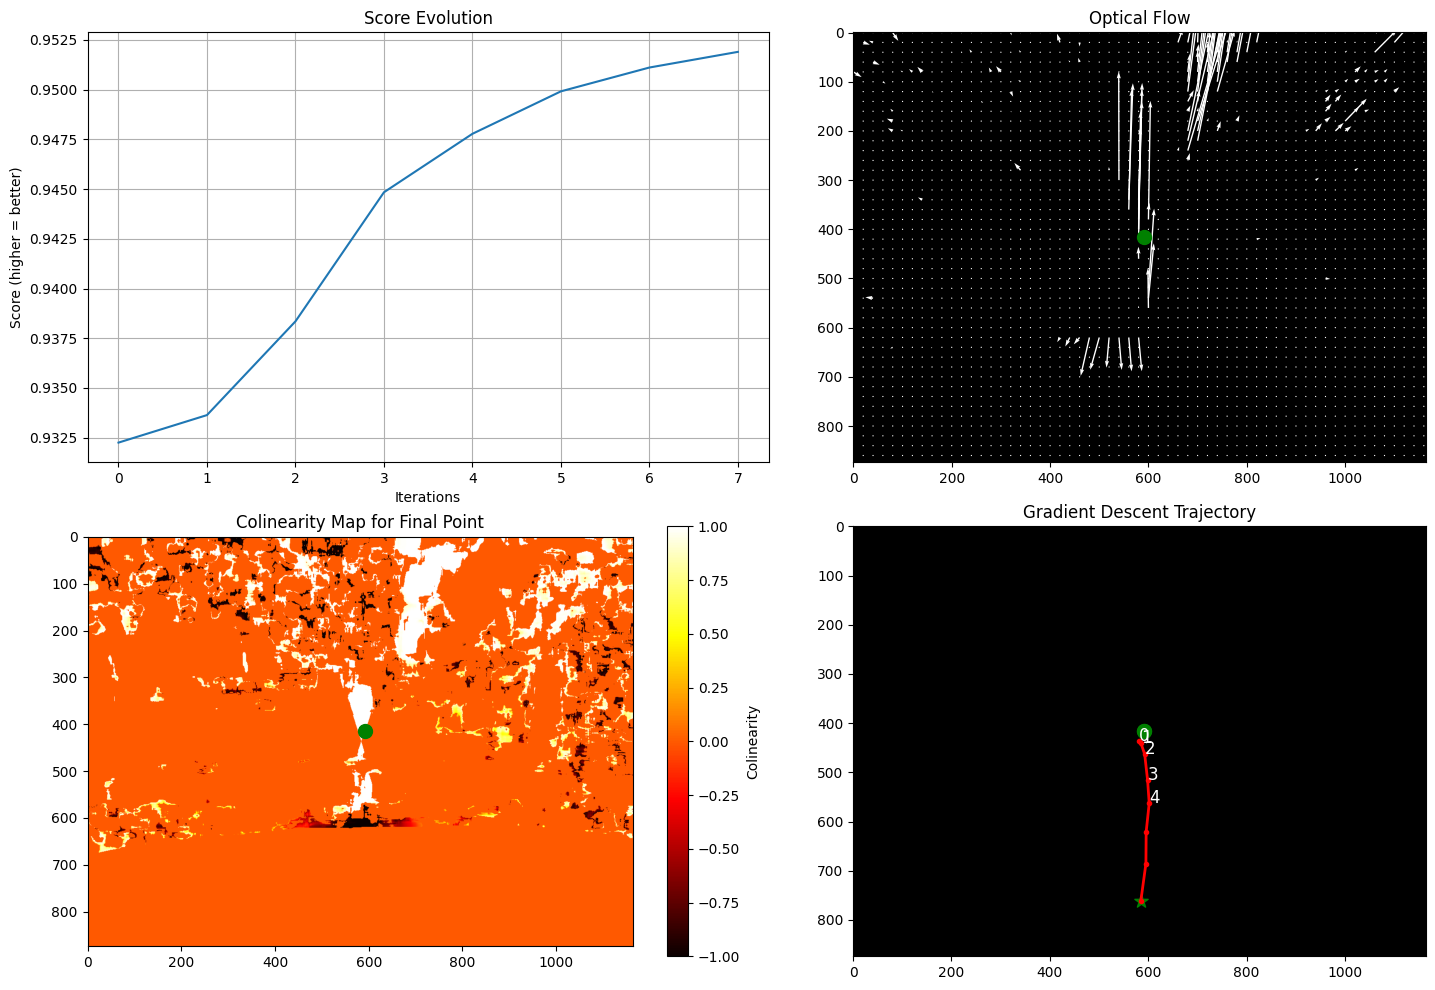

In [25]:
ve.initial_vanishing_point = (ve.center_x, ve.center_y)
predicted_vanishing_point = ve.find_vanishing_point_lbfgsb(
    filtered_flow, 
    visualize=True,
    ground_truth_point=label_point
)

# Fonctions de calcul de l'objectif et des gradients

In [26]:
def objective_function(point, flow, step=10):
    """
    Calcule un score global de colinéarité pour un point candidat
    
    Args:
        point: Tuple (x, y) représentant le point candidat
        flow: Champ de vecteurs de flow optique de forme (h, w, 2)
        
    Returns:
        score: Valeur numérique, plus élevée signifie meilleure colinéarité globale
    """
    # Calculer la carte de colinéarité
    colinearity_map = compute_colinearity_map(flow, point, step)
    
    # Ne pas utiliser la valeur absolue pour différencier flow entrant et sortant
    # Nous voulons conserver le signe de la colinéarité
    
    # Calculer le score moyen (ignorer les pixels qui n'ont pas de flow significatif)
    valid_pixels = (flow[:,:,0]**2 + flow[:,:,1]**2) > 1e2
    if np.sum(valid_pixels) > 0:
        score = np.sum(colinearity_map * valid_pixels) / np.sum(valid_pixels)
    else:
        score = 0
    
    # Négatif car nous voulons minimiser dans la descente de gradient
    return -score

def compute_gradient(point, flow, epsilon=1.0, step=10):
    """
    Calcule le gradient de la fonction objectif par rapport aux coordonnées du point
    
    Args:
        point: Tuple (x, y) représentant le point candidat
        flow: Champ de vecteurs de flow optique
        epsilon: Petit déplacement pour l'approximation numérique
        
    Returns:
        gradient: Tuple (dx, dy) représentant le gradient
    """
    x, y = point
    
    # Évaluer la fonction objectif au point actuel
    f_current = objective_function(point, flow, step)
    
    # Évaluer la fonction après un petit déplacement en x
    f_x_plus = objective_function((x + epsilon, y), flow, step)
    
    # Évaluer la fonction après un petit déplacement en y
    f_y_plus = objective_function((x, y + epsilon), flow)
    
    # Calculer les dérivées partielles
    df_dx = (f_x_plus - f_current) / epsilon
    df_dy = (f_y_plus - f_current) / epsilon
    
    return (df_dx, df_dy)

def visualize_gradient_descent(flow, trajectory, scores, final_point, ground_truth_point):
    """
    Visualise les résultats de la descente de gradient
    
    Args:
        flow: Champ de vecteurs de flow optique
        trajectory: Liste des points visités pendant la descente
        scores: Liste des scores à chaque itération
        final_point: Point final (x, y)
    """
    h, w = flow.shape[:2]
    
    plt.figure(figsize=(15, 10))
    
    # Tracer l'évolution du score
    plt.subplot(2, 2, 1)
    plt.plot([-s for s in scores])
    plt.title('Évolution du score')
    plt.xlabel('Itérations')
    plt.ylabel('Score (plus élevé = meilleur)')
    plt.grid(True)
    
    # Visualiser le champ de flow optique
    plt.subplot(2, 2, 2)
    
    # Créer une grille pour visualiser le flow
    Y, X = np.mgrid[0:h:20, 0:w:20]
    U = flow[::20, ::20, 0]
    V = flow[::20, ::20, 1]
    
    plt.imshow(np.zeros((h, w, 3)), cmap='gray')
    plt.quiver(X, Y, U, -V, color='w', scale=50)
    plt.scatter(ground_truth_point[0], ground_truth_point[1], c='green', s=100, marker='o', label='Ground truth')
    plt.title('Flow optique')
    
    # Visualiser la carte de colinéarité pour le point final
    plt.subplot(2, 2, 3)
    colinearity_map = compute_colinearity_map(flow, final_point)
    plt.imshow(colinearity_map, cmap='hot')
    plt.colorbar(label='Colinéarité')
    plt.scatter(ground_truth_point[0], ground_truth_point[1], c='green', s=100, marker='o', label='Ground truth')
    plt.title('Carte de colinéarité pour le point final')
    
    # Visualiser la trajectoire de la descente
    plt.subplot(2, 2, 4)
    plt.imshow(np.zeros((h, w, 3)))
    
    # Convertir la liste de tuples en array numpy pour faciliter le tracé
    trajectory_array = np.array(trajectory)
    plt.plot(trajectory_array[:, 0], trajectory_array[:, 1], 'r.-', linewidth=2)
    plt.scatter(final_point[0], final_point[1], c='g', s=100, marker='*')
    plt.scatter(ground_truth_point[0], ground_truth_point[1], c='green', s=100, marker='o', label='Ground truth')
    
    # Ajouter des annotations pour les premiers points
    for i, (x, y) in enumerate(trajectory[:min(5, len(trajectory))]):
        plt.annotate(f"{i}", (x, y), fontsize=12, color='white')
    
    plt.title('Trajectoire de la descente de gradient')
    plt.xlim(0, w)
    plt.ylim(h, 0)  # Inverser l'axe y pour correspondre aux coordonnées d'image
    plt.scatter(ground_truth_point[0], ground_truth_point[1], c='green', s=100, marker='o', label='Ground truth')
    
    plt.tight_layout()
    plt.show()

# Fonctions d'optimisation de l'objectif

In [27]:
from scipy.optimize import minimize

def find_vanishing_point_lbfgsb(flow, initial_point=None, visualize=True, step=10, ground_truth_point=None):
    """
    Trouve le point de fuite en utilisant l'algorithme L-BFGS-B
    
    Args:
        flow: Champ de vecteurs de flow optique de forme (h, w, 2)
        initial_point: Point initial (x, y). Si None, utilise le centre de l'image
        visualize: Booléen indiquant s'il faut visualiser les résultats
        
    Returns:
        vanishing_point: Tuple (x, y) représentant le point de fuite estimé
    """
    h, w = flow.shape[:2]
    
    # Si pas de point initial fourni, utiliser le centre de l'image
    if initial_point is None:
        initial_point = [w // 2, h // 2]
    
    # Points et scores pour visualisation
    all_points = [initial_point]
    all_scores = [objective_function(initial_point, flow, step)]
    
    # Fonction callback pour enregistrer la trajectoire
    def callback(point):
        all_points.append(point.copy())
        all_scores.append(objective_function(point, flow, step))
    
    # Optimisation avec L-BFGS-B sans bornes strictes
    result = minimize(
        lambda point: objective_function(point, flow, step),
        initial_point,
        method='L-BFGS-B',
        callback=callback if visualize else None,
        options={'disp': False}
    )
    
    vanishing_point = tuple(result.x)
    
    if visualize:
        visualize_gradient_descent(flow, all_points, all_scores, vanishing_point, ground_truth_point)
    
    return vanishing_point

def gradient_descent_vanishing_point(flow, initial_point=None, learning_rate=10.0, 
                                    max_iterations=100, tolerance=1e-5, visualize=True, step=10):
    """
    Trouve le point de fuite par descente de gradient standard
    
    Args:
        flow: Champ de vecteurs de flow optique
        initial_point: Point initial (x, y)
        learning_rate: Taux d'apprentissage
        max_iterations: Nombre maximum d'itérations
        tolerance: Seuil de convergence
        visualize: Afficher les résultats intermédiaires
        
    Returns:
        vanishing_point: Point de fuite estimé (x, y)
    """
    h, w = flow.shape[:2]
    
    # Point initial au centre si non spécifié
    if initial_point is None:
        initial_point = (w // 2, h // 2)
    
    # Stocker la trajectoire et les scores
    current_point = initial_point
    trajectory = [current_point]
    current_score = objective_function(current_point, flow, step)
    scores = [current_score]
    
    # Boucle principale de descente de gradient
    for iteration in range(max_iterations):
        # Calculer le gradient
        grad_x, grad_y = compute_gradient(current_point, flow, step)
        
        # Mettre à jour le point
        new_x = current_point[0] - learning_rate * grad_x
        new_y = current_point[1] - learning_rate * grad_y
        new_point = (new_x, new_y)
        
        # Calculer le nouveau score
        new_score = objective_function(new_point, flow, step)
        
        # Stocker les résultats
        trajectory.append(new_point)
        scores.append(new_score)
        
        # Afficher la progression
        if iteration % 10 == 0:
            print(f"Itération {iteration}: point = {new_point}, score = {-new_score:.6f}")
        
        # Vérifier la convergence
        if abs(new_score - current_score) < tolerance:
            print(f"Convergence atteinte après {iteration+1} itérations")
            break
        
        # Ajuster le taux d'apprentissage si nécessaire (optionnel)
        if new_score > current_score:  # Si le score se dégrade
            learning_rate *= 0.5  # Réduire le taux d'apprentissage
            print(f"Réduction du taux d'apprentissage à {learning_rate}")
            # Revenir au point précédent
            new_point = current_point
            new_score = current_score
        
        # Mettre à jour pour l'itération suivante
        current_point = new_point
        current_score = new_score
    
    # Visualiser les résultats
    if visualize:
        visualize_gradient_descent(flow, trajectory, scores, current_point)
    
    return current_point

In [36]:
from ground_truth import get_frame_pixels

gt = get_frame_pixels(video_index, frame_index)
obj = objective_function(gt, flow)
print(f"objective: {obj}")


objective: -0.9641600182205541


In [29]:
pred = vanishing_point = find_vanishing_point_lbfgsb(flow, 
                                              initial_point=pt, 
                                              visualize=False, 
                                              step=10,
                                              ground_truth_point=(pt[0], pt[1])
                                            )
obj = objective_function(pred, flow)
print(f"objective: {obj}")


objective: -0.9938182129768011


# Find optimal parameters for the flow function

In [13]:
flow, _, _ = calculate_flow(gray1, gray2, combined_mask)
prev_gray_masked = gray1.copy()
gray_masked = gray2.copy()
prev_gray_masked[combined_mask > 0] = 0
gray_masked[combined_mask > 0] = 0
    
# Trouver les paramètres optimaux pour le flow optique
best_obj = float('inf')
best_params = {}

# Paramètres à tester
pyr_scales = [0.7]
levels_list = [5, 6, 7]
winsizes = [21,23,25, 27]
iterations_list = [2,3,4]
poly_n_list = [5]
poly_sigma_list = [0.8, 0.9, 1.0]

# Recherche par grille pour trouver les meilleurs paramètres
# Calculer le nombre total d'itérations
total_iterations = len(pyr_scales) * len(levels_list) * len(winsizes) * len(iterations_list) * len(poly_n_list) * len(poly_sigma_list)
current_iteration = 0

for pyr_scale in pyr_scales:
    for levels in levels_list:
        for winsize in winsizes:
            for iterations in iterations_list:
                for poly_n in poly_n_list:
                    for poly_sigma in poly_sigma_list:
                        # Calculer le flow optique avec ces paramètres
                        flow = cv2.calcOpticalFlowFarneback(
                            prev_gray_masked, gray_masked, None,
                            pyr_scale=pyr_scale,
                            levels=levels,
                            winsize=winsize,
                            iterations=iterations,
                            poly_n=poly_n,
                            poly_sigma=poly_sigma,
                            flags=0
                        )
                        # Update and print progress
                        current_iteration += 1
                        print(f"Progression: {current_iteration}/{total_iterations} ({current_iteration/total_iterations*100:.1f}%)")
                        
                        # Évaluer l'objectif
                        obj = objective_function(pt, flow)
                        
                        # Mettre à jour les meilleurs paramètres si nécessaire
                        if obj < best_obj:
                            best_obj = obj
                            best_params = {
                                'pyr_scale': pyr_scale,
                                'levels': levels,
                                'winsize': winsize,
                                'iterations': iterations,
                                'poly_n': poly_n,
                                'poly_sigma': poly_sigma
                            }
                            print(f"Nouvelle meilleure valeur: {best_obj} avec {best_params}")

# Calculer le flow final avec les meilleurs paramètres
print(f"Meilleurs paramètres: {best_params}")
print(f"Meilleure valeur objective: {best_obj}")

flow = cv2.calcOpticalFlowFarneback(
    prev_gray_masked, gray_masked, None,
    **best_params,
    flags=0
)
obj = objective_function(pt, flow)

Progression: 1/108 (0.9%)
Nouvelle meilleure valeur: -0.9660115370463518 avec {'pyr_scale': 0.7, 'levels': 5, 'winsize': 21, 'iterations': 2, 'poly_n': 5, 'poly_sigma': 0.8}
Progression: 2/108 (1.9%)
Nouvelle meilleure valeur: -0.9661910192991469 avec {'pyr_scale': 0.7, 'levels': 5, 'winsize': 21, 'iterations': 2, 'poly_n': 5, 'poly_sigma': 0.9}
Progression: 3/108 (2.8%)
Progression: 4/108 (3.7%)
Progression: 5/108 (4.6%)
Progression: 6/108 (5.6%)
Progression: 7/108 (6.5%)
Progression: 8/108 (7.4%)
Progression: 9/108 (8.3%)
Progression: 10/108 (9.3%)
Nouvelle meilleure valeur: -0.9664328438691132 avec {'pyr_scale': 0.7, 'levels': 5, 'winsize': 23, 'iterations': 2, 'poly_n': 5, 'poly_sigma': 0.8}
Progression: 11/108 (10.2%)
Progression: 12/108 (11.1%)
Progression: 13/108 (12.0%)
Progression: 14/108 (13.0%)
Progression: 15/108 (13.9%)
Progression: 16/108 (14.8%)
Progression: 17/108 (15.7%)
Progression: 18/108 (16.7%)
Progression: 19/108 (17.6%)
Progression: 20/108 (18.5%)
Progression: 21

KeyboardInterrupt: 

# Filter out the vecors leading to error

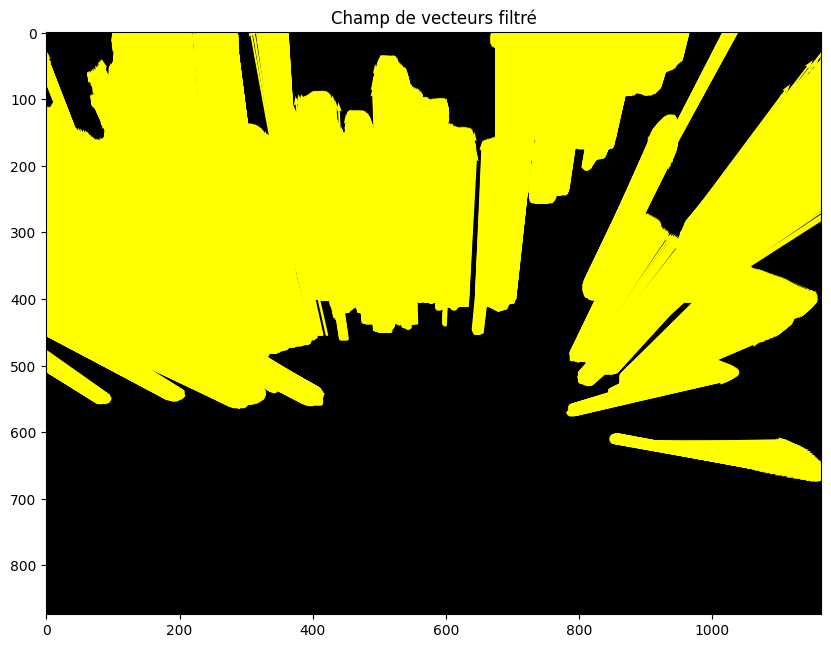

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_vector_field(flow, valid_mask=None, figsize=(10, 10), color='yellow', 
                          scale=50, title='Champ de vecteurs filtré'):
    """
    Visualize a vector field using quiver plot.
    
    Args:
        flow (array): Flow field of shape (h, w, 2)
        valid_mask (array, optional): Boolean mask of valid vectors to display
        figsize (tuple): Figure size as (width, height)
        color (str): Color for the vectors
        scale (float): Scale factor for the quiver plot
        title (str): Title for the plot
    """
    h, w = flow.shape[:2]
    y, x = np.mgrid[0:h, 0:w]
    
    if valid_mask is None:
        valid_mask = np.ones((h, w), dtype=bool)
    
    x_valid = x[valid_mask]
    y_valid = y[valid_mask]
    u_valid = flow[:, :, 0][valid_mask]
    v_valid = flow[:, :, 1][valid_mask]
    
    plt.figure(figsize=figsize)
    plt.imshow(np.zeros((h, w)), cmap='gray')
    plt.quiver(x_valid, y_valid, u_valid, -v_valid, color=color, scale=scale)
    # plt.gca().invert_yaxis()  # <--- Inverse l'axe des y
    plt.title(title)
    plt.show()

# Filter the flow vectors
h, w = flow.shape[:2]
valid_pixels = (flow[:, :, 0]**2 + flow[:, :, 1]**2) > 1e2

# Visualize the filtered flow
visualize_vector_field(flow, valid_pixels)

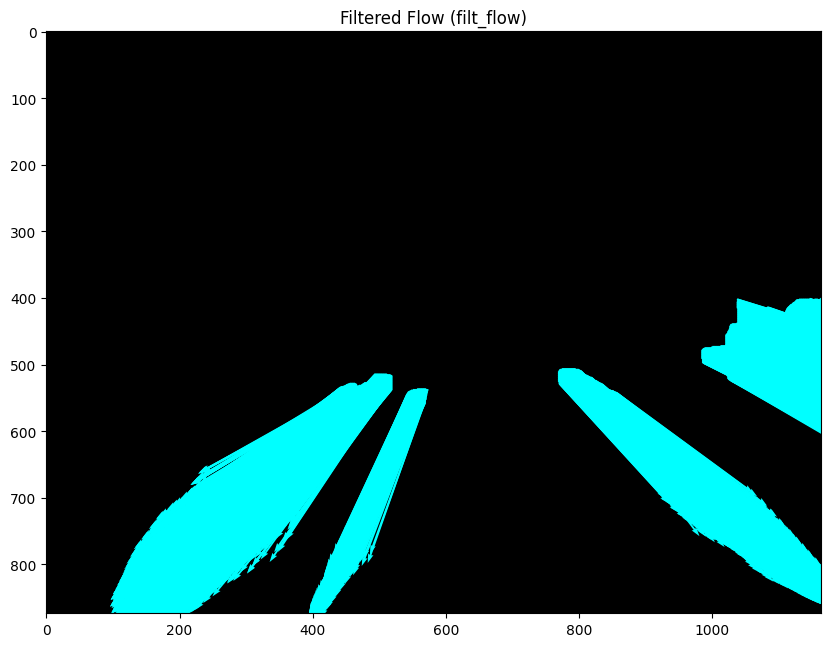

Original flow shape: (874, 1164, 2)
Filtered flow shape: (874, 1164, 2)
Percentage of vectors kept: 2.33%


In [33]:
# Create filtered flow based on the previous cell
# We'll create a new flow array where we keep only the vectors with significant magnitude

# Create a copy of the original flow
filt_flow = flow.copy()

# Create a mask for vectors with small magnitude (less than threshold)
small_vectors_mask = (flow[:, :, 0]**2 + flow[:, :, 1]**2) <= 1e2

# Set small vectors to zero in the filtered flow
filt_flow[small_vectors_mask] = 0

# Visualize the filtered flow
plt.figure(figsize=(10, 10))
plt.imshow(np.zeros((h, w)), cmap='gray')
plt.quiver(x[~small_vectors_mask], y[~small_vectors_mask], 
           filt_flow[:, :, 0][~small_vectors_mask], 
           -filt_flow[:, :, 1][~small_vectors_mask], 
           color='cyan', scale=50)
plt.title('Filtered Flow (filt_flow)')
plt.show()

print(f"Original flow shape: {flow.shape}")
print(f"Filtered flow shape: {filt_flow.shape}")
print(f"Percentage of vectors kept: {100 * (~small_vectors_mask).sum() / (h*w):.2f}%")


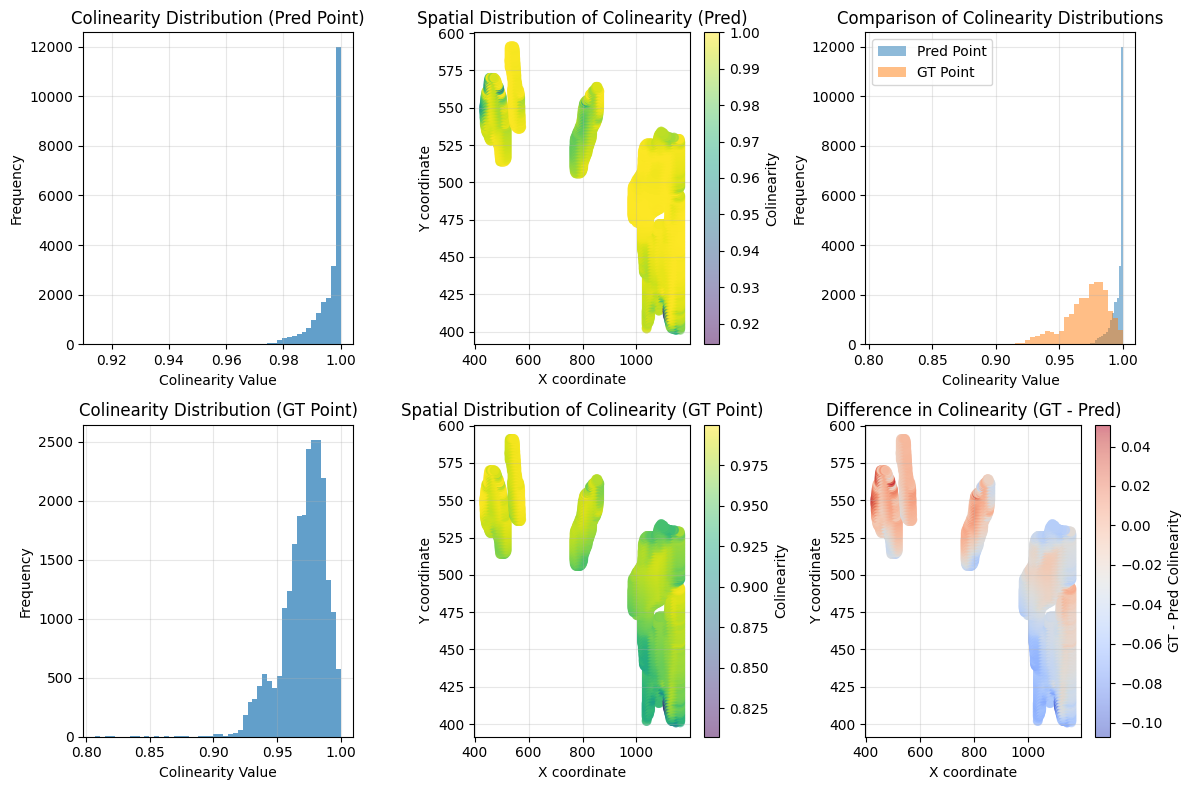

Prediction point colinearity stats:
  Mean: 0.9959
  Median: 0.9983
  Min: 0.9143
  Max: 1.0000
  Std: 0.0058

Ground truth point colinearity stats:
  Mean: 0.9709
  Median: 0.9743
  Min: 0.8073
  Max: 1.0000
  Std: 0.0176


In [39]:
# Define a new function to compute colinearity for multiple points
def compute_colinearity_for_points(pt, x_coords, y_coords, u_flow, v_flow):
    """
    Compute colinearity between a reference point and multiple flow vectors.
    
    Args:
        pt (tuple): Reference point (x, y)
        x_coords (array): X coordinates of flow vectors
        y_coords (array): Y coordinates of flow vectors
        u_flow (array): X components of flow vectors
        v_flow (array): Y components of flow vectors
        
    Returns:
        array: Colinearity values for each point
    """
    # Initialize array to store colinearity values
    colinearity_values = np.zeros(len(x_coords))
    
    # Calculate colinearity for each point
    for i in range(len(x_coords)):
        # Vector from reference point to current point
        vec_to_point = np.array([x_coords[i] - pt[0], y_coords[i] - pt[1]])
        
        # Flow vector at current point
        flow_vec = np.array([u_flow[i], v_flow[i]])
        
        # Normalize vectors
        vec_to_point_norm = np.linalg.norm(vec_to_point)
        flow_vec_norm = np.linalg.norm(flow_vec)
        
        # Avoid division by zero
        if vec_to_point_norm > 0 and flow_vec_norm > 0:
            vec_to_point = vec_to_point / vec_to_point_norm
            flow_vec = flow_vec / flow_vec_norm
            
            # Compute dot product (colinearity)
            colinearity = np.abs(np.dot(vec_to_point, flow_vec))
            colinearity_values[i] = colinearity
    
    return colinearity_values

# Get non-filtered flow vectors
non_filtered_mask = ~small_vectors_mask
x_non_filtered = x[non_filtered_mask]
y_non_filtered = y[non_filtered_mask]
u_non_filtered = flow[:, :, 0][non_filtered_mask]
v_non_filtered = flow[:, :, 1][non_filtered_mask]

# Try different reference points and compute colinearity
# Use our prediction point
pred_pt = (vanishing_point[0], vanishing_point[1])
colinearity_pred = compute_colinearity_for_points(
    pred_pt, 
    x_non_filtered, 
    y_non_filtered, 
    u_non_filtered, 
    v_non_filtered
)

# Use the ground truth point
gt_pt = (gt_x, gt_y)
colinearity_gt = compute_colinearity_for_points(
    gt_pt, 
    x_non_filtered, 
    y_non_filtered, 
    u_non_filtered, 
    v_non_filtered
)

# Plot the distribution of colinearities
plt.figure(figsize=(12, 8))

# Histogram of colinearity values for prediction point
plt.subplot(2, 3, 1)
plt.hist(colinearity_pred, bins=50, alpha=0.7)
plt.title(f'Colinearity Distribution (Pred Point)')
plt.xlabel('Colinearity Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Scatter plot of colinearity values for prediction point
plt.subplot(2, 3, 2)
plt.scatter(x_non_filtered, y_non_filtered, c=colinearity_pred, cmap='viridis', alpha=0.5)
plt.colorbar(label='Colinearity')
plt.title('Spatial Distribution of Colinearity (Pred)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True, alpha=0.3)

# Histogram for ground truth point
plt.subplot(2, 3, 4)
plt.hist(colinearity_gt, bins=50, alpha=0.7)
plt.title(f'Colinearity Distribution (GT Point)')
plt.xlabel('Colinearity Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Scatter plot for ground truth point
plt.subplot(2, 3, 5)
plt.scatter(x_non_filtered, y_non_filtered, c=colinearity_gt, cmap='viridis', alpha=0.5)
plt.colorbar(label='Colinearity')
plt.title('Spatial Distribution of Colinearity (GT Point)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True, alpha=0.3)

# Comparison of distributions
plt.subplot(2, 3, 3)
plt.hist(colinearity_pred, bins=50, alpha=0.5, label='Pred Point')
plt.hist(colinearity_gt, bins=50, alpha=0.5, label='GT Point')
plt.title('Comparison of Colinearity Distributions')
plt.xlabel('Colinearity Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Difference in colinearity
plt.subplot(2, 3, 6)
plt.scatter(x_non_filtered, y_non_filtered, c=colinearity_gt-colinearity_pred, cmap='coolwarm', alpha=0.5)
plt.colorbar(label='GT - Pred Colinearity')
plt.title('Difference in Colinearity (GT - Pred)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics about the colinearity distributions
print(f"Prediction point colinearity stats:")
print(f"  Mean: {np.mean(colinearity_pred):.4f}")
print(f"  Median: {np.median(colinearity_pred):.4f}")
print(f"  Min: {np.min(colinearity_pred):.4f}")
print(f"  Max: {np.max(colinearity_pred):.4f}")
print(f"  Std: {np.std(colinearity_pred):.4f}")

print(f"\nGround truth point colinearity stats:")
print(f"  Mean: {np.mean(colinearity_gt):.4f}")
print(f"  Median: {np.median(colinearity_gt):.4f}")
print(f"  Min: {np.min(colinearity_gt):.4f}")
print(f"  Max: {np.max(colinearity_gt):.4f}")
print(f"  Std: {np.std(colinearity_gt):.4f}")


# Rest

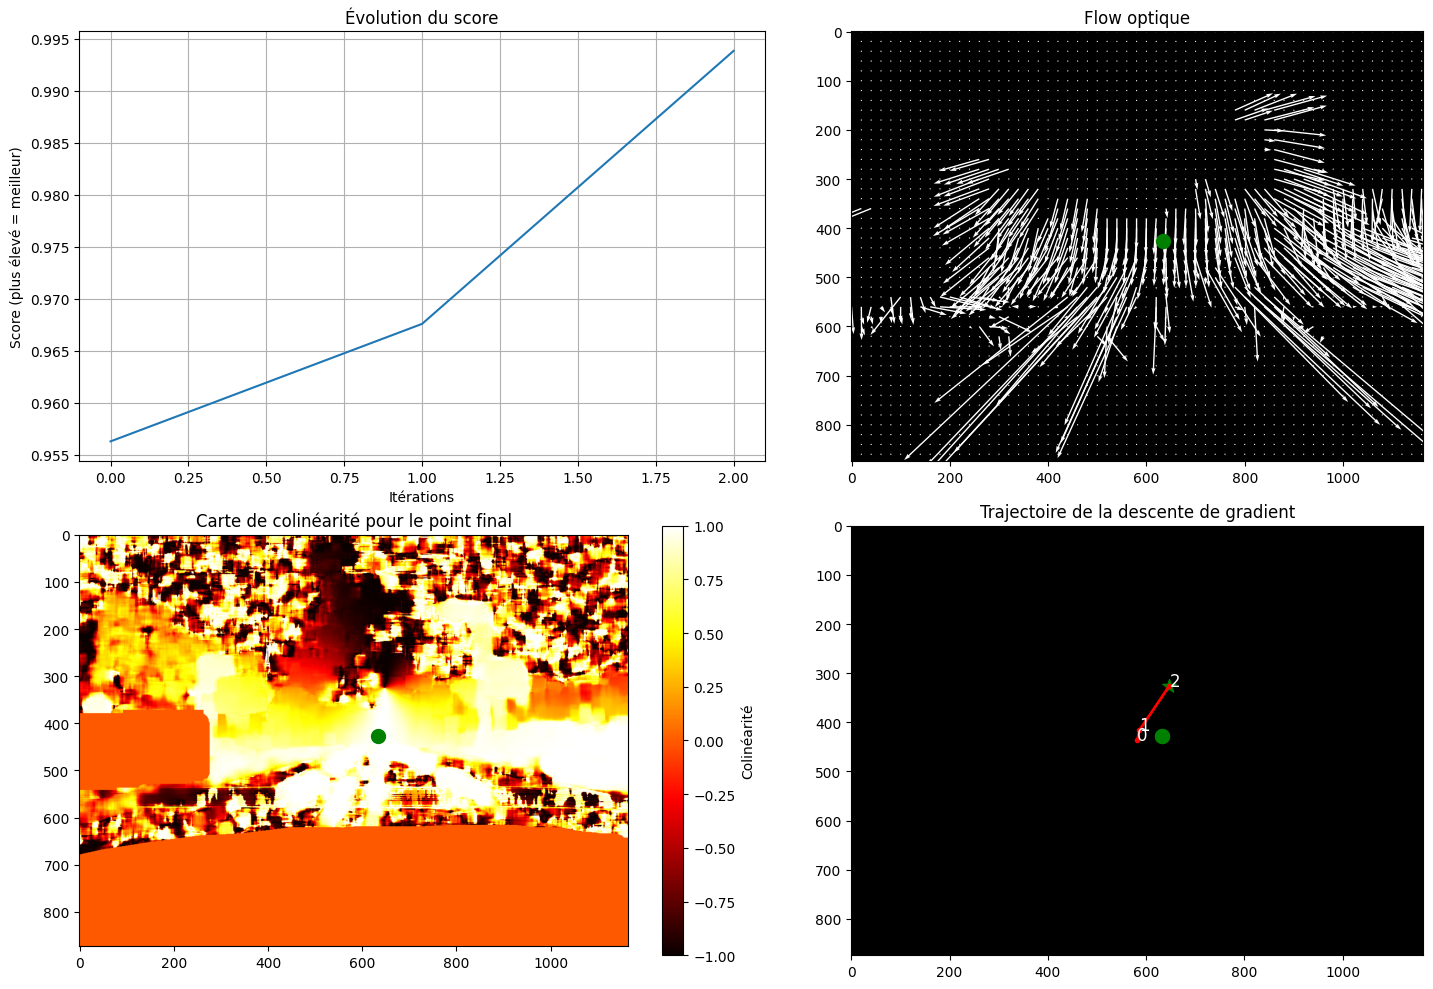

Point de fuite estimé (x, y): (np.float64(647.0440346996713), np.float64(325.9847891435653))


In [19]:
# Tester la fonction find_vanishing_point_lbfgsb avec les données existantes
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow
from ground_truth import get_frame_pixels

# Supposons que nous avons déjà calculé le flow optique dans une cellule précédente
# Utilisons le point central comme point initial
h, w = flow.shape[:2]
initial_point = None

image_width = w
image_height = h
gt_x, gt_y = get_frame_pixels(video_index, frame_index)
# Appliquer l'algorithme L-BFGS-B pour trouver le point de fuite
vanishing_point = find_vanishing_point_lbfgsb(flow, 
                                              initial_point=initial_point, 
                                              visualize=True, 
                                              step=10,
                                              ground_truth_point=(gt_x, gt_y)
                                            # learning_rate=10000, 
                                            # max_iterations=100, 
                                            # tolerance=1e-10
                                            )

print(f"Point de fuite estimé (x, y): {vanishing_point}")

# # Visualiser le résultat sur l'image
# plt.figure(figsize=(12, 8))
# plt.imshow(np.zeros_like(flow[:,:,0]), cmap='gray')  # Fond noir pour mieux voir les flèches

# # Afficher un échantillon du flow optique
# step = 30  # Afficher une flèche tous les 30 pixels
# for y in range(0, h, step):
#     for x in range(0, w, step):
#         if np.any(flow[y, x] != 0):  # Vérifier que le flow n'est pas nul à cette position
#             plt.arrow(x, y, flow[y, x, 0], flow[y, x, 1], 
#                      head_width=5, head_length=5, fc='yellow', ec='yellow', alpha=0.5)

# # Marquer le point de fuite estimé
# vp_x, vp_y = vanishing_point
# plt.scatter(vp_x, vp_y, c='red', s=100, marker='x', label='Point de fuite estimé')

# # Marquer le point initial
# # plt.scatter(initial_point[0], initial_point[1], c='blue', s=100, marker='o', label='Point initial')

# # Afficher le point de ground truth
# # video_index = 0  # Ajuster selon la vidéo utilisée
# # frame_index = 0  # Ajuster selon la frame utilisée
# # focal_length = 1000  # Ajuster selon votre configuration
# image_width = w
# image_height = h
# gt_x, gt_y = get_frame_pixels(video_index, frame_index, focal_length, image_width, image_height)
# plt.scatter(gt_x, gt_y, c='green', s=100, marker='o', label='Ground truth')

# plt.title(f"Point de fuite estimé: ({vp_x:.2f}, {vp_y:.2f})")
# plt.legend()
# plt.axis('off')
# plt.tight_layout()
# plt.show()
